# Aujourd'hui on roule sur les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [8]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [9]:
def load_data(file,data_path=DATA_PROCESSED, sep=';'):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep=';')

# On load les jeux de données

In [10]:
TX_data = load_data(file = "train.csv");

In [11]:
TX_data.drop(['CARD_PAYMENT','COUPON_PAYMENT','RSP_PAYMENT','WALLET_PAYMENT'], axis = 1, inplace = True)

In [12]:
TX_data.info() # 42 colonnes, c'est un nombre qui fait plaisir. [Note, il y en a plus maintenant, mais ce commentaire me fait toujours rire]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 57 columns):
SHIPPING_MODE                 100000 non-null object
SHIPPING_PRICE                100000 non-null int64
WARRANTIES_FLG                100000 non-null bool
WARRANTIES_PRICE              100000 non-null int64
PRICECLUB_STATUS              100000 non-null int64
REGISTRATION_DATE             100000 non-null int64
PURCHASE_COUNT                100000 non-null int64
BUYER_BIRTHDAY_DATE           100000 non-null float64
BUYER_DEPARTMENT              100000 non-null int64
BUYING_DATE                   100000 non-null int64
SELLER_SCORE_COUNT            100000 non-null int64
SELLER_SCORE_AVERAGE          100000 non-null float64
SELLER_COUNTRY                100000 non-null object
SELLER_DEPARTMENT             100000 non-null int64
PRODUCT_TYPE                  100000 non-null object
PRODUCT_FAMILY                100000 non-null object
ITEM_PRICE                    100000 non-null int64

### Split entre train et test

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.3, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )
del TX_data;

# Jointure entre les X et Y

In [14]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    try :
        Y=data["CLAIM_TYPE"]
        X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    except:
        Y=0
        X=data
    # Exclude Objets
    X=X.select_dtypes(exclude=['object']) # j'exclude les variables catégorielles que j'ai oublié
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [15]:
X_train, Y_train = datapreprocess(train_set)
X_test, Y_test = datapreprocess(test_set)

gc.collect()

681

In [16]:
def multiclass_roc_auc_score(truth, pred):
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

# MODEL!

In [18]:
from sklearn.utils.class_weight import compute_sample_weight

In [19]:
sample_weight_arr = compute_sample_weight(class_weight='balanced', y=Y_train)

## XGBoost

#### Core XGBoost Library VS scikit-learn API

Models can be trained in two different ways:

1. Directly using the core library – this is closer to the implementation of the caret-package in R
2. Using the scikit-learn API – this means that the models are implemented in a way that lets the scikit package recognize it as one of it’s own models.

Nous, on va travailler avec l'API de Sklearn, c'est pas optimisé mais plus simple. De toute façon, j'arrive pas à utiliser le Core, a cause des DMatrix qui veulent que des numerics en entrées

Doc des paramètres: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

Doc sur le tunning : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [20]:
from xgboost import XGBClassifier

###  XGBoost solo

In [22]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    #'nthread':4, # Je le commente, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 1000,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.1,
    'min_child_weight' : 1, #A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
    'max_depth' : 3,
    #'max_leaf_nodes':None, #If this is defined, GBM will ignore max_depth.
    'gamma' : 0.3,
    'max_delta_step':7, #it might help in logistic regression when class is extremely imbalanced/ 1-10 might help control the update
    'subsample' : 0.55,
    'colsample_bytree' : 0.85,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'reg_alpha':0,
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax', # you also need to set an additional num_class (number of classes)
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
}

In [23]:
xgb_clf = XGBClassifier(**params_XGB)

In [24]:
params_XGB_fit={
    'X':X_train, 
    'y':Y_train, 
    'sample_weight':sample_weight_arr, 
    'eval_set':None, 
    'eval_metric':'auc', 
    'early_stopping_rounds':None, 
    'verbose':True, 
    'xgb_model':None
}

In [25]:
xgb_clf.fit(**params_XGB_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, eval_metric='auc', gamma=0.3,
       learning_rate=0.1, max_delta_step=7, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_class=8, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=array([ 0.84411,  0.84411, ...,  0.25011,  0.25011]),
       seed=42, silent=0, subsample=0.55)

In [26]:
y_pred_xgb_train = xgb_clf.predict(X_train)
y_pred_xgb = xgb_clf.predict(X_test)

In [27]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_xgb_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_xgb)

In [28]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))

Performance sur le train : 0.6702775270441699
Performance sur le test : 0.6185115309943839


Performance sur le train : 0.6589482571844301

Performance sur le test : 0.6180906043249655


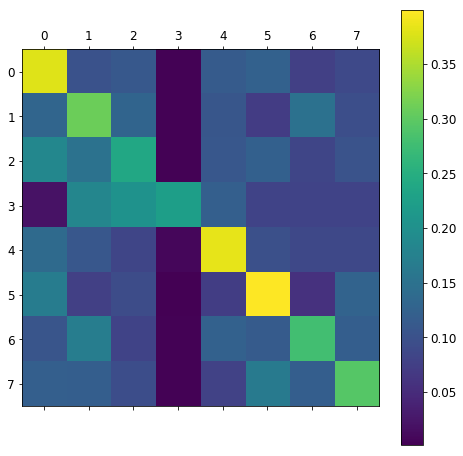

In [29]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

#### C'est un beau score pour le XBoost

Cependant, j'ai optimisé pour la mauvaise métrique, et j'ai toujours pas fait le Grid Search

In [30]:
pd.DataFrame(xgb_clf.feature_importances_, index=X_train.columns, columns=["Feature"]).sort_values(by="Feature", ascending=False)

,Feature
BUYER_BIRTHDAY_DATE,0.074132
Mean_Claims_Sells_ID,0.064765
STD_Claims_Sells_ID,0.061227
Count_Sells_ID,0.055269
Count_PRODUCT_TYPE,0.041612
STD_Claims_PRODUCT_TYPE,0.039028
BUYER_DEPARTMENT,0.038019
Mean_Claims_PRODUCT_TYPE,0.035508
BUYER_DEPARTMENT_cmb,0.034646
REGISTRATION_DATE,0.034243


In [ ]:
sortie en erreur les copines!

### XGBoost Grid Search Iterate

Comme mon PC est pourri, je vais chercher les paramètres de façon iterative

In [ ]:
from sklearn.model_selection import GridSearchCV

#### Paramètres pour le XGB qui ne changent pas

In [ ]:
params_XGB={
# General Parameters -  the overall functioning
    'booster':'gbtree',
    'silent':0,
    #'nthread':4, # Je vais le commenter, puisque il détecte automatiquement le nombre de cores qu'il peut utiliser.
    'n_estimators' : 100,
    
# Booster Parameters - the individual booster (tree/regression) at each step
    'learning_rate' : 0.1,
    'colsample_bylevel':1, #default
    'reg_lambda' : 1, #default
    'scale_pos_weight' : sample_weight_arr,

# Learning Task Parameters -  the optimization performed
    'objective' : 'multi:softmax',
    'num_class' : len(Y_train.unique()),
    'eval_metric':"auc",
    'seed' : RANDOM_SEED,
}

#### Paramètres pour la méthode `fit` de XGB qui ne changent pas

In [ ]:
fit_params_xgb_cv={
    'sample_weight': sample_weight_arr, 
    'eval_set' : None, 
    'eval_metric' : 'auc', 
    'early_stopping_rounds' : None, 
    'verbose':True, 
    'xgb_model':None
}

###  Optim 1 : max_depth, min_child_weight et max_delta_step

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'max_depth':range(2,5),
    'min_child_weight':range(1,6),
    'max_delta_step':list(range(1,5)),
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `max_depth` :
2. `min_child_weight` :
3. `max_delta_step` :
    

###  Optim 2 : gamma, et subsample

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `gamma` :
2. `subsample` :

###  Optim 3 : colsample_bytree, et reg_alpha

In [ ]:
# Paramètres pour le GridSearch
params_XGB_CV = {
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [ ]:
xgb_gs_cv = GridSearchCV(XGBClassifier(**params_XGB), 
                              params_XGB_CV,
                              n_jobs=-1,
                              verbose=1)

In [ ]:
xgb_gs_cv.fit(
    X = X_train, 
    y=Y_train, 
    groups=None, 
    **fit_params_xgb_cv
)
print(xgb_gs_cv.best_estimator_)
print("ROC score : {}".format(multiclass_roc_auc_score(Y_test, xgb_gs_cv.predict(X_test))))

Donc les paramètres optimaux sont:
1. `colsample_bytree` :
2. `reg_alpha` :

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_xgb_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)